# 06. Monte Carlo Sampling

With __Monte Carlo sampling__, also referred to as __parametric bootstrap__, the probabiliy distribution of model parameters is approximated by generating a large number of artificial measurements (resampling) and re-estimating model parameters for each. 

For a detailed description of the method the interested reader is referred to:

- [Diciccio, Thomas J., and Joseph P. Romano. “A Review of Bootstrap Confidence Intervals.” Journal of the Royal Statistical Society. Series B (Methodological) 50, no. 3 (1988): 338–54.](https://www.jstor.org/stable/2345699)
- [M. Joshi, A. Seidel-Morgenstern, A. Kremling,
"Exploiting the bootstrap method for quantifying parameter confidence intervals in dynamical systems,
Metabolic Engineering",
Volume 8, Issue 5,
2006,
Pages 447-455](https://www.sciencedirect.com/science/article/pii/S1096717606000243)

### Imports

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
from estim8.error_models import LinearErrorModel
import pandas as pd

## 6.1 Load the model 

In [2]:
SimpleBatchModel = FmuModel(path='../tests/test_data/SimpleBatch.fmu')

## 6.2 Import experimental data & create an `Experiment` object
To quantify the extend at which uncertainty in experimental data propagates to parameter estimates, we need to define it first using a mathematical model.

Per default, `estim8` assumes normally distributed measurement noise, e.g. using the `LinearErrorModel` introduced in [Notebook 2. Experimental data and error modeling](2.%20Experimental%20data%20and%20error%20modeling.ipynb). 

In [3]:
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0, 1))
data.columns = data.columns.droplevel(1)
print(data.head())

# use a linear error model with normally distributed noise
experiment = datatypes.Experiment(data, error_model=LinearErrorModel(slope=0.05, offset=0.1))

Time         X   S
0.0   0.176200 NaN
0.1   0.318313 NaN
0.2   0.285270 NaN
0.3   0.218600 NaN
0.4   0.248210 NaN


## 6.3 Defining the estimation problem & create `Estimator` object
As described in [Notebook 3. Parameter estimation](3.%20Parameter%20estimation.ipynb), unknown parameters and their bounds are defined and an `Estimator` instance is created.

In [4]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

# create an estimator object
estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,
    data=experiment,
    t=[0, 10, 0.1],
    metric="negLL"
)

## 6.4 Start Monte Carlo Sampling
Monte carlo sampling runs an optimization for each generated sample, therefore the method provides the same arguments and keyword arguments as a single estimation job using the `Estimator`'s `estimate` method:

| Argument | Type | Description |
|----------|------|-------------|
| method   | str or List[str] | the method key of the optimization algorithm. Pygmo algorithms are passed as a List[str] |
| max_iter | int  | maximum iteration rounds for the solver algorithm per estimation job.|
|           |   |           |
| Kwarg | Type | Description |
| n_jobs   | int | number of parallel jobs to run the optimization algorithm with for each estimation job |
| optimizer_kwargs | dict  | Keyword arguments for the optimization function |

Additionall arguments and keyword arguments for the `mc_sampling` method are

| Kwarg | Type | Description |
|----------|------|-------------|
| n_samples | int | The number of Monte Carlo samples |
| mcs_at_once   | int | number of Monte carlo estimations run in parallel |
| optimizer_kwargs | dict  | keyword arguments for the optimization function |


⚠️ This method puts considerable amount of work on your machine!

In [5]:
mc_samples = estimator.mc_sampling(
    method='de',        
    max_iter=1000,      # maximum iterations for each estimation run 
    n_jobs=1,           # parallelization of each estimation run 
    mcs_at_once=6,      # number of Monte Carlo estimations to run in parallel
    n_samples=300       # number of monte carlo samples
)

---- Sample 1 completed
---- Sample 2 completed
---- Sample 3 completed
---- Sample 4 completed
---- Sample 5 completed
---- Sample 6 completed
---- Sample 7 completed
---- Sample 8 completed
---- Sample 9 completed
---- Sample 10 completed
---- Sample 11 completed
---- Sample 12 completed
---- Sample 13 completed
---- Sample 14 completed
---- Sample 15 completed
---- Sample 16 completed
---- Sample 17 completed
---- Sample 18 completed
---- Sample 19 completed
---- Sample 20 completed
---- Sample 21 completed
---- Sample 22 completed
---- Sample 23 completed
---- Sample 24 completed
---- Sample 25 completed
---- Sample 26 completed
---- Sample 27 completed
---- Sample 28 completed
---- Sample 29 completed
---- Sample 30 completed
---- Sample 31 completed
---- Sample 32 completed
---- Sample 33 completed
---- Sample 34 completed
---- Sample 35 completed
---- Sample 36 completed
---- Sample 37 completed
---- Sample 38 completed
---- Sample 39 completed
---- Sample 40 completed
---- Samp

## 6.5 Evaluation of Monte Carlo Sampling

For further evaluation and saving the sampling results e.g. to an Excel-file, the Monte Carlo samples `mc_samples` are stored in a `pandas.DataFrame`. This dataframe can then be passed to the different evaluation plot methods provided by the `visualization` submodule.

In [6]:
samples = pd.DataFrame(data = [elem[0] for elem in mc_samples]) # extract the parameter - estimate dictionary frome each sample and create a pandas DataFrame
samples.index.name = 'sample'
samples.head()

,X0,mu_max,Y_XS
sample,,,
0,0.086779,0.514876,0.493391
1,0.094593,0.506151,0.498500
2,0.087864,0.515612,0.497193
3,0.104462,0.491988,0.489170
4,0.089755,0.512506,0.502189


### 6.5.1 Forward simulation plot of Monte Carlo samples
The first step when evaluating the sampling result should be a "posterior check". For this matter, the `plot_estimates` method shows the density of resulting model predictions compared to experimental data. 

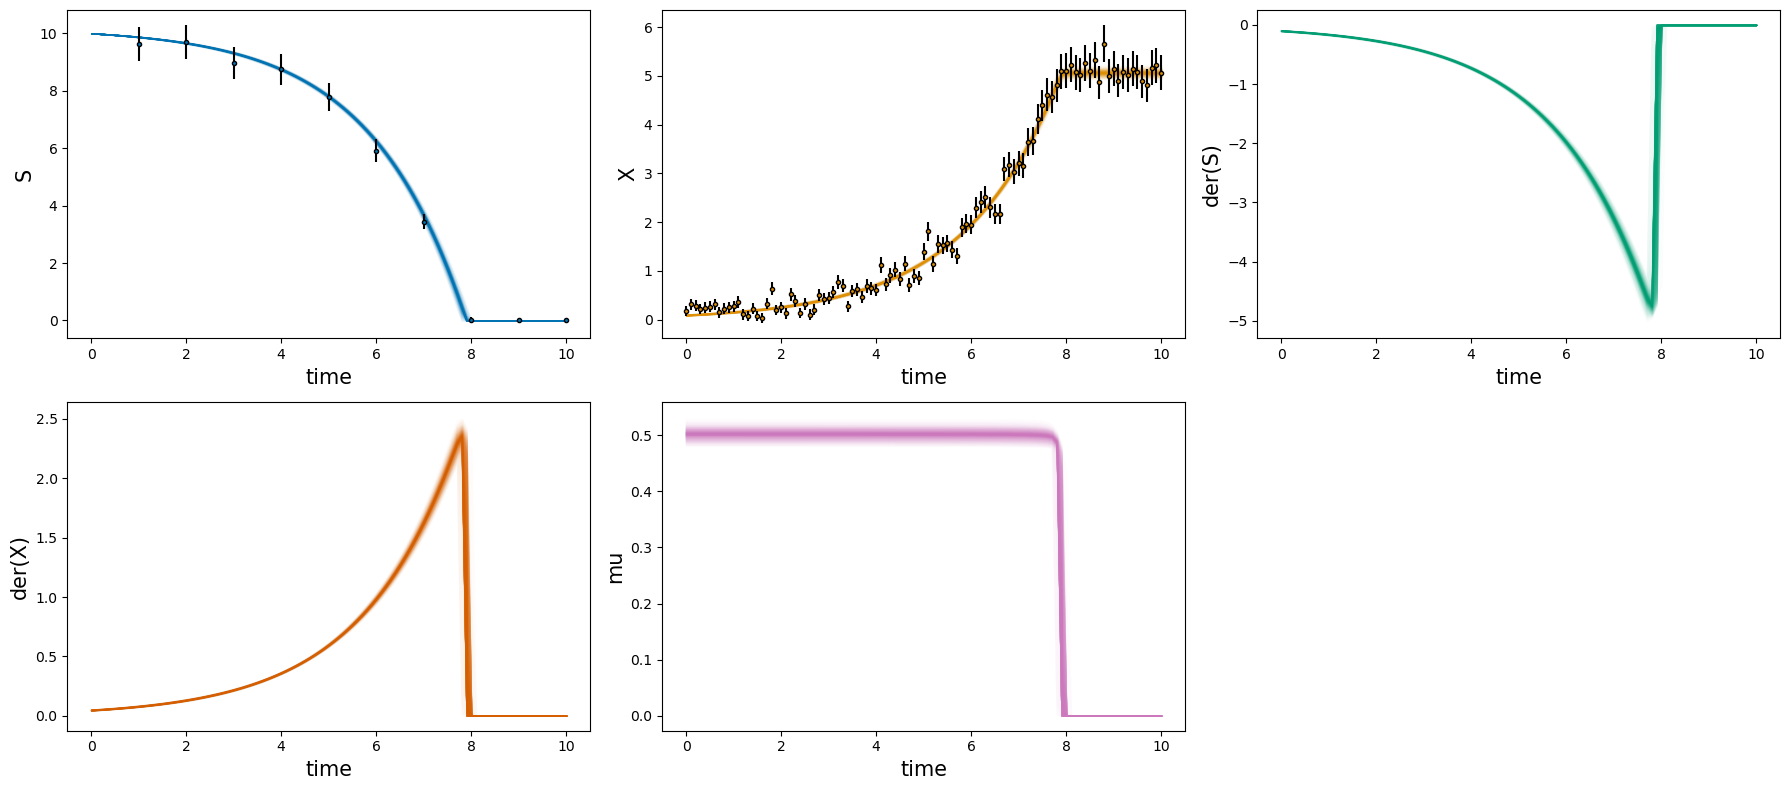

In [7]:
# forward simulations
_ = visualization.plot_estimates_many(mc_samples=samples, estimator=estimator)

### 6.5.2 Parameter distributions

The `plot_distributions` method can then be used to plot the parameter distributions via histograms along with statistical metrics of sampling mean and confidence interval ( 95 % in the example below). 

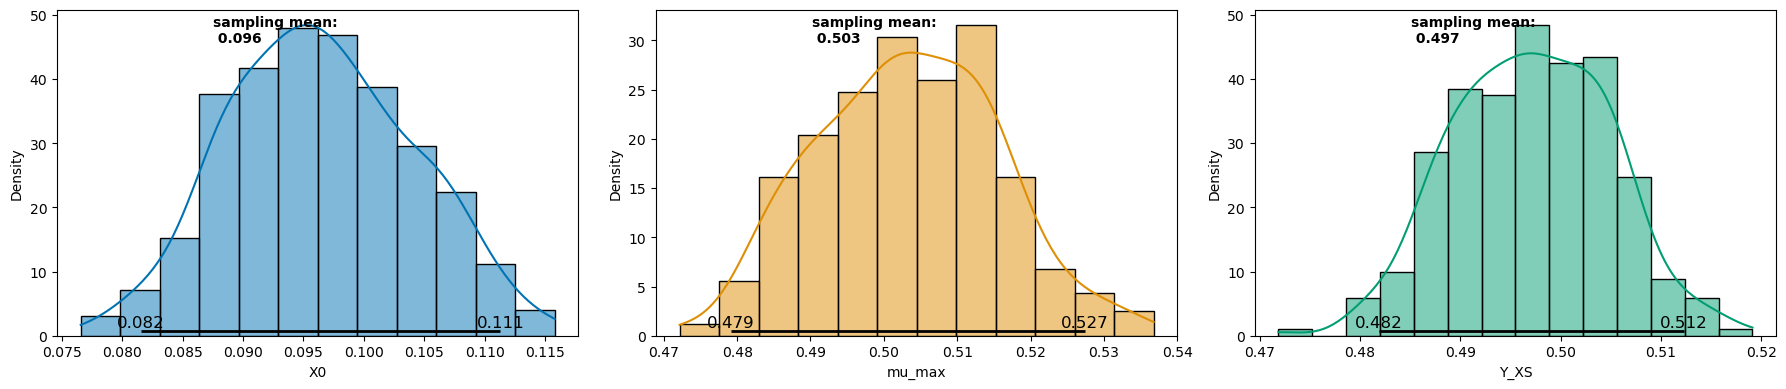

In [8]:
_ = visualization.plot_distributions(samples, ci_level=0.95)

### 6.5.3 Pair plots

Finally, parameter correlations can be revealed using the `plot_pairs` method.

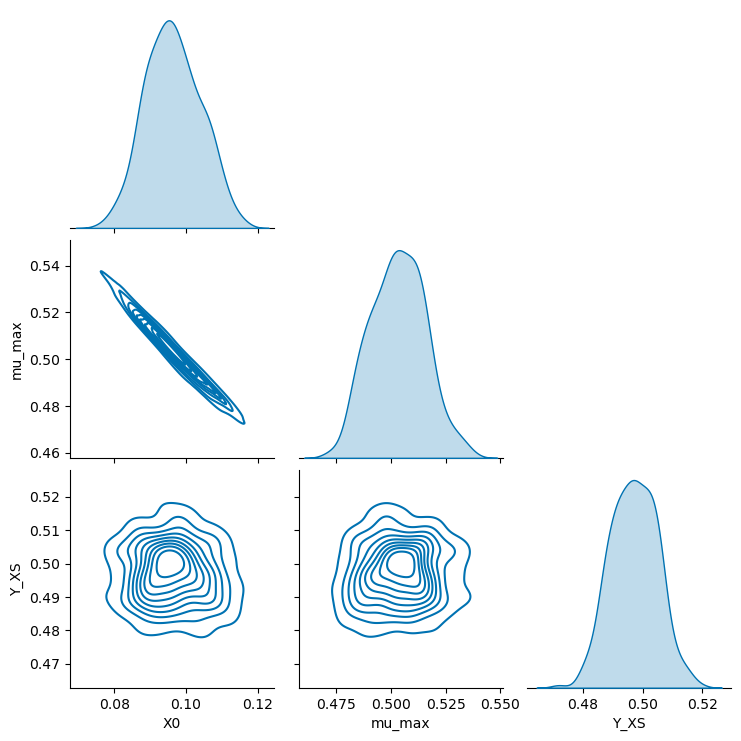

In [9]:
_ = visualization.plot_pairs(samples, kind="kde")

## 6.6 Custom distributions

Since there are many possible distributions to describe such an error, we did not provide a selection, but instead enable the use of any `scipy.stats.rv_continuous` distribution. For more information, please check out the section `3.2.3 Custom error models` in [Notebook 2](2.%20Experimental%20data%20and%20error%20modeling.ipynb).

